# Detection of Cardiac Arrhythmia from ECG Sequence

This is a standard test set in anomaly detection. The model is trained on an inlier class consisting of the first 5000 points. Subsequent points are then scored against the trained model. A delay embedding is used to create a richer 4-dimensional feature set.

This uses both the static `predict_proba()` detection method and the dynamic sequence detection method `predict_sequence()` on ECG data. The specific data can be downloaded [here](http://www.physionet.org/cgi-bin/ATM) selecting Select MIT-BIH Arrhythmia Database ( _mitdb_ ), and exporting as a CSV.

The data was initially prepared from the CSV by applying a median filter with a kernel size of 301:
```
X = np.loadtxt(
    "data/MIT_physionet_sample.csv", skiprows=2, usecols=(1, 2), delimiter=","
)

# Apply a median filter with a window size of 301
X[:, 0] = X[:, 0] - scipy.signal.medfilt(X[:, 0], kernel_size=301)
X[:, 1] = X[:, 1] - scipy.signal.medfilt(X[:, 1], kernel_size=301)
```

For efficiency, the data used here has the median filter 
applied and is in `/notebooks/filtered_ecg.json`.

In [1]:
import os
import numpy as np
from pathlib import Path

cwd = os.getcwd()
os.chdir(Path(cwd).parents[1])

from lsanomaly import LSAnomaly
import lsanomaly.notebooks.dynamic as demo

### Data Prep

In [2]:
X_train, X_test = demo.data_prep(
    data_file=os.path.join(
        os.getcwd(), "lsanomaly", "notebooks", "filtered_ecg.json"
    )
)

## Anomaly Models

In [3]:
anomaly_model = LSAnomaly(rho=1.0, sigma=0.5)
anomaly_model.fit(X_train)

### Static Detection

In [4]:
y_pred_static = anomaly_model.predict_proba(X_test)

### Dynamic Detection
Because the dynamic model uses an Hidden Markov Model, a state transition matrix $A$ 
and an initial probability vector $\pi$ are required.
We set

$$
\begin{equation*}
A = 
\begin{pmatrix}
0.999 & 0.001 \\
0.01 & 0.99 \\
\end{pmatrix}
\end{equation*}
$$
and
$$\pi = (0.5, .05)$$

In [5]:
A = np.array([[0.999, 0.001], [0.01, 0.99]])
pi = np.array([0.5, 0.5])

In [6]:
y_pred_dynamic = anomaly_model.predict_sequence(
    X_test, A, pi, inference="smoothing"
)

## RESULTS

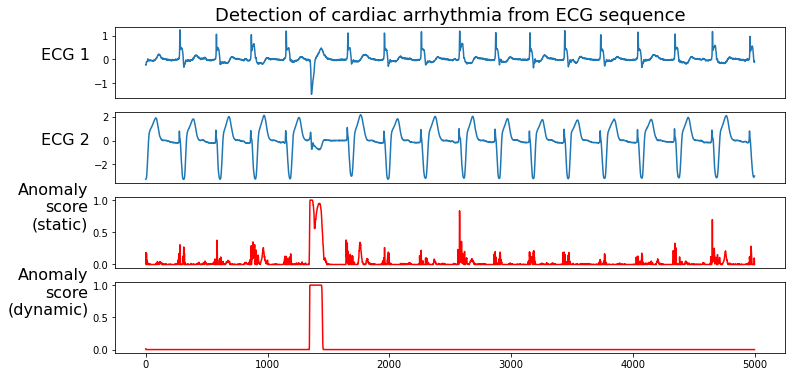

In [7]:
demo.plot_results(X_test, y_pred_static, y_pred_dynamic, static_threshold=0.85);